[View in Colaboratory](https://colab.research.google.com/github/arpitsharma9/01_machine_learning/blob/master/02_cnn/cifar10_cnn_tpu_ver.1.0.ipynb)

# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN to classify images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database - TPU Version

In [0]:
## Load basic libraries

#https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
#https://colab.research.google.com/drive/1rP91Q5L1mPOVt7FcKkqFJSIMZrBtDawO#scrollTo=Ug4jYDExTpUT
import os
from time import time
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [426]:
# check tensorflow version, we want the one that support eager mode
tf.__version__

'1.12.0-rc1'

In [427]:
# Check if eager execution mode is on
tf.executing_eagerly()

False

In [428]:
from tensorflow.keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train_full, y_train_full),(x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train_full.shape)
print(x_train_full.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [429]:
# create validation set
split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42)
print('x_train: {}, y_train: {}, x_val: {}, y_val: {}'
      .format(x_train.shape, y_train.shape, x_val.shape, y_val.shape))

x_train: (40000, 32, 32, 3), y_train: (40000, 1), x_val: (10000, 32, 32, 3), y_val: (10000, 1)


In [0]:
## define some variables
batch_size = 1024
num_classes = 10
epochs = 50
data_augmentation = True
#data_augmentation = False
num_predictions = 10
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'

### 2. Visualize the First 36 Training Images

In [0]:
# pick 36 random images and plot
idxs = np.random.randint(x_train.shape[0], size=36)
images = x_train[idxs]
labels = y_train[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


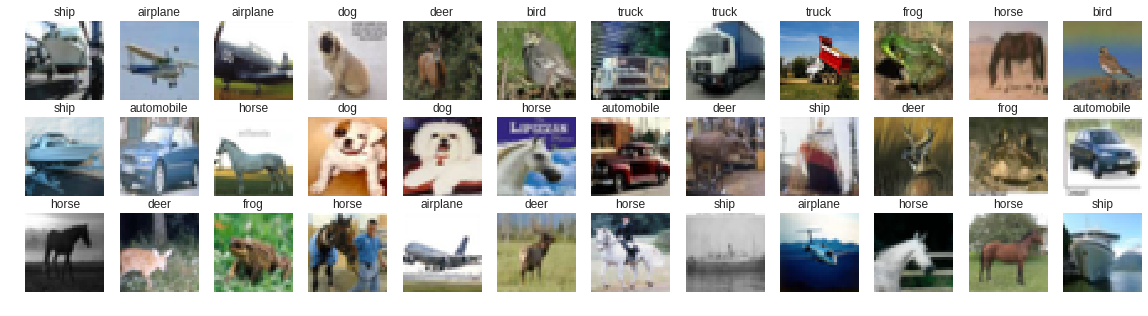

In [432]:
fig, axes = plt.subplots(3,12, figsize=(20,5))
#print(type(axes)) - there would be 36 elements in this numpy array - 3*12= 36 ... 3- row, 12 - column
## numpy.ndarray.flat¶ - A 1-D iterator over the array.
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i][0]
  ax.set_title(classnames[idx])

plt.show()

In [433]:
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    idx=y_train[i][0]
    #print(idx)
    ax.set_title(classnames[idx])
'''    

'\nimport numpy as np\nimport matplotlib.pyplot as plt\n%matplotlib inline\n\nfig = plt.figure(figsize=(20,5))\nfor i in range(36):\n    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])\n    ax.imshow(np.squeeze(x_train[i]))\n    idx=y_train[i][0]\n    #print(idx)\n    ax.set_title(classnames[idx])\n'

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [0]:
# rescale [0,255] --> [0,1]
# If we do not convert this to float, then most of the values will be zero... 240/255=0, but 240.0/255=0.94
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [435]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))
#y_train = tf.keras.utils.to_categorical(y_train, num_classes)
#y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# break training set into training and validation sets
#(x_train, x_valid) = x_train[5000:], x_train[:5000]
#(y_train, y_valid) = y_train[5000:], y_train[:5000]
x_train, x_valid,y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, random_state=42)


# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (36000, 32, 32, 3)
36000 train samples
10000 test samples
4000 validation samples


In [0]:

def train_gen(batch_size):
  while True:
    ## A singl Random value of offset will be returned between # of training examples - batch size
    offset = np.random.randint(0, x_train.shape[0] - batch_size)
    # A subset of train input and output samples starting from offset till batch size will be generated.
    # In below case, if offset is 1000 and batch size is 1024, a subset of training examples set from 1000-2024  will be generated.
    yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]
 


### 5. Define the Model Architecture 

In [437]:
## define the model architecture

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
batch_normalization_31 (Batc (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 3, 3, 128)         73856     
__________

### 6. Compile the Model 

In [438]:
import os
import pprint

## not using TPU's
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  # This address identifies the TPU we'll use when configuring TensorFlow.
  #TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']  
  #print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  #print('TPU devices:')
  #pprint.pprint(devices)
  

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)
    )
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.119.23.226:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 3320117251004430255)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8473923159629118968)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6234453474984506342)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 271920621677968681)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 16011065633738674831)
INFO:tensorflow:*** Available Device: _DeviceA

### 6. Image augmentation to the data

In [439]:
if not data_augmentation:
    print('Not using data augmentation.')
    
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)


Using real-time data augmentation.


### 8. Train the Model 

In [0]:
# compile the model
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# use below optimizer if you are running on TPU

#opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
#opt=tf.train.RMSPropOptimizer(learning_rate=0.01,decay=1e-6)
'''
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
'''

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    #optimizer=tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=1e-6),
    #optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [441]:

# train the model

start = time()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
'''
hist = model.fit(x_train, y_train, batch_size=32, epochs=5,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)
'''
# Fit the model on the batches generated by datagen.flow().

if not data_augmentation:
  '''
  hist = tpu_model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)
  '''
  hist =tpu_model.fit_generator(
    train_gen(batch_size), epochs=epochs, 
    steps_per_epoch=np.ceil(x_train.shape[0]/batch_size),
    validation_data = (x_val, y_val),callbacks=[checkpointer])


else:
  print("in this loop 2")
  hist = tpu_model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        steps_per_epoch=np.ceil(x_train.shape[0]/batch_size),
                        validation_data=(x_valid, y_valid),callbacks=[checkpointer],verbose=1)
  
end = time()

in this loop 2
Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_370'), TensorSpec(shape=(128, 32, 32, 3), dtype=tf.float32, name='conv2d_95_input_10'), TensorSpec(shape=(128, 1), dtype=tf.float32, name='activation_34_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_95_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 25.331260442733765 secs
INFO:tensorflow:Setting weights on TPU model.
35/36 [============================>.] - ETA: 1s - loss: 2.1235 - sparse_categorical_accuracy: 0.2687INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(20,), dtype=tf.int32, name='core_id_370'), TensorSpec(shape=(20, 32, 32, 3), dtype=tf.float32, name='conv2d_95_input_10'), TensorSpec(shape=(20, 1), dtype=tf.float32, name='activation_34_target_10')]
INFO:tensorflow:Ov

In [442]:
print('Total training time {} seconds'.format(end - start))

Total training time 1424.6247634887695 seconds


### 9. Load the Model with the Best Validation Accuracy

In [0]:
# load the weights that yielded the best validation accuracy
tpu_model.load_weights('model.weights.best.hdf5')

### 10. Calculate Classification Accuracy on Test Set

In [444]:
# evaluate and print test accuracy
score = tpu_model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_380'), TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='conv2d_95_input_10'), TensorSpec(shape=(4, 1), dtype=tf.float32, name='activation_34_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_95_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 28.357956647872925 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(2,), dtype=tf.int32, name='core_id_380'), TensorSpec(shape=(2, 32, 32, 3), dtype=tf.float32, name='conv2d_95_input_10'), TensorSpec(shape=(2, 1), dtype=tf.float32, name='activation_34_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_95_input
INFO:tensorflow:Started compiling
INFO:tensorflow:

### 11. Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.

In [0]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  
  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
    
  plt.show()

### 11.1 Plot Loss and Accuracy

Lets see how did we do on training and validation sets

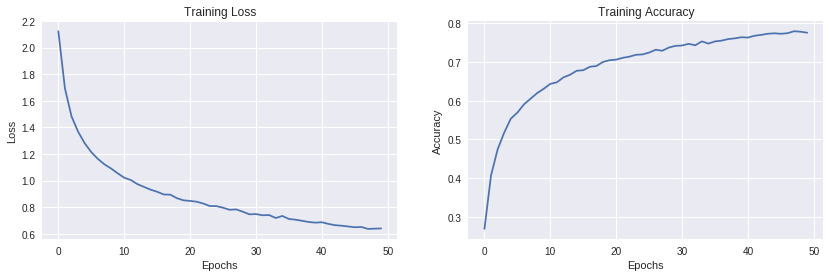

In [446]:
# Training
plot(hist.history['loss'], 
     hist.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

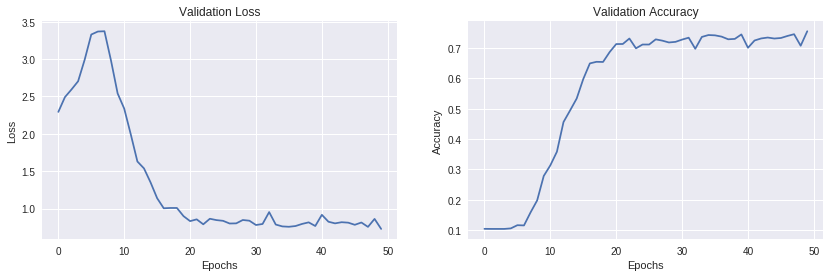

In [447]:
# Validation
plot(hist.history['val_loss'], 
     hist.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

# Test accuracy

Next, we plot the model predictions on test set

In [448]:
c = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU


In [453]:
# get predictions on the test set
y_hat = cpu_model.predict(x_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#y_hat[0]*100 - max probabilty for cat.
#y_test[0] - cat
np.argmax(y_hat[0])
#print(y_hat[0],y_test[0])


[0.02440951 0.0147304  0.21890797 0.39359194 0.03437747 0.25506106
 0.0147304  0.0147304  0.0147304  0.0147304 ] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


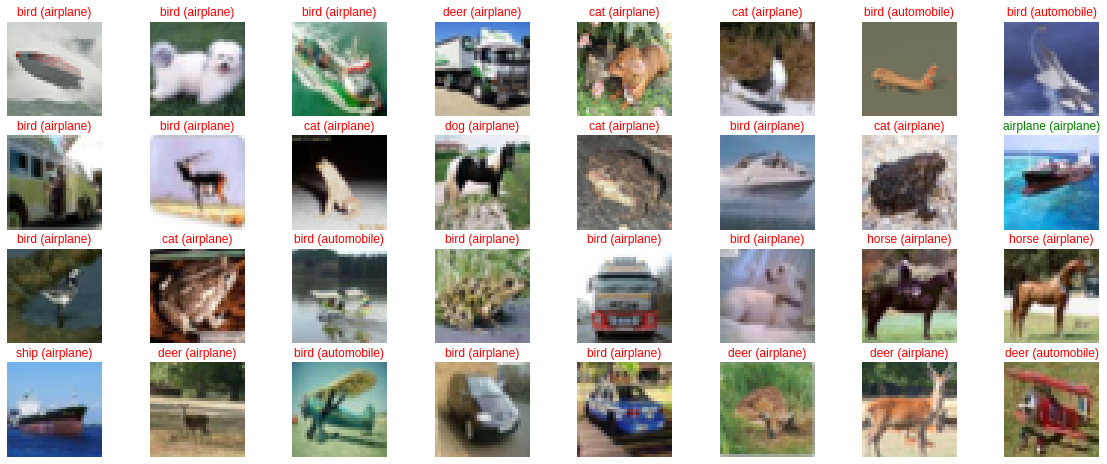

In [456]:
# plot a random sample of test images, their predicted labels, and ground truth
##x_test.shape[0] - basically i get the number of samples in testset.. i.e 10,000
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ## argmax will returns the indices of the maximum values along an axis.
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [451]:
'''
idxs = np.random.randint(x_test.shape[0], size=25)
images = x_test[idxs]
#true_labels = y_test[idxs]

true_labels =np.argmax(y_test,axis=1)
preds = np.argmax(cpu_model.predict(images), axis=1)
print(true_labels)
'''

'\nidxs = np.random.randint(x_test.shape[0], size=25)\nimages = x_test[idxs]\n#true_labels = y_test[idxs]\n\ntrue_labels =np.argmax(y_test,axis=1)\npreds = np.argmax(cpu_model.predict(images), axis=1)\nprint(true_labels)\n'

In [452]:
'''
fig, axes = plt.subplots(5,5, figsize=(8,9))
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = preds[i]
  color = ('g' if idx == true_labels[i] else 'r')
  ax.set_title(classnames[idx], color=color)

plt.show()
'''

"\nfig, axes = plt.subplots(5,5, figsize=(8,9))\nfor i, ax in enumerate(axes.flat):\n  ax.imshow(images[i])\n  ax.axis('off')\n  idx = preds[i]\n  color = ('g' if idx == true_labels[i] else 'r')\n  ax.set_title(classnames[idx], color=color)\n\nplt.show()\n"